In [138]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import shuffle
from collections import Counter
import random
import matplotlib.pyplot as plt
from nltk.util import ngrams
import nltk
import spacy
import string
import pickle as pkl

nltk.download('punkt')
%matplotlib inline

    Step 1: Read data

In [33]:
data_file_path = os.getcwd() + '/data'

In [60]:
def read_data(data_file_path):
    #read files from train and test folders separately
    for folders in ['train','test']:
        path = data_file_path + '/' + folders
        pos = list()
        for f in os.listdir(path + '/pos'):
            if f.split('.')[1] == 'txt':
                f_content = open(path + '/pos/' + f, 'r+')
                pos.append(f_content.read())
    
        y_pos = np.ones(len(pos))  
    
        neg = list()
        for m in os.listdir(path + '/neg'):
            if m.split('.')[1] == 'txt':
                m_content = open(path + '/neg/' + m, 'r+')
                neg.append(m_content.read())
        y_neg = np.zeros(len(neg))
        
        if folders == 'train':
            train = pd.DataFrame({'reviews': pos,'y':y_pos}).append(pd.DataFrame({'reviews': neg,'y':y_neg}))
        if folders == 'test':
            test = pd.DataFrame({'reviews': pos,'y':y_pos}).append(pd.DataFrame({'reviews': neg,'y':y_neg}))
        
    # Split train data into actual train and validation sets
    shuffle(train)
    train_split = 20000
    train_data = train[:train_split]
    vali_data = train[train_split:]
    
    return train_data, vali_data, test

In [477]:
train, vali, test = read_data(data_file_path)

In [478]:
print ("Train dataset size is {}".format(len(train)))
print ("Val dataset size is {}".format(len(vali)))
print ("Test dataset size is {}".format(len(test)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


    Step 2: Tokenize

1-gram tokenize

In [76]:
punctuations = string.punctuation

#use nltk to tokenize the dataset, which is faster
#and implement n-grams all at one function
def tokenize_dataset_ngram(dataset,n_gram):
    token_dataset = []
    all_tokens = []
    
    for text in dataset:
        #tokenize and remove punctuations
        tokens = nltk.word_tokenize(text)
        tokens = [token.lower() for token in tokens if (token not in punctuations)]
        
        n_grams_tokens = ngrams(tokens,n_gram)
        n_grams_tokens = [ ' '.join(grams) for grams in n_grams_tokens]
        token_dataset.append(n_grams_tokens)
        all_tokens += n_grams_tokens

    return token_dataset, all_tokens


In [364]:
#save all tokens in local for convenience
# val set tokens
print ("Tokenizing validation data")
vali_data_tokens, _ = tokenize_dataset_ngram(vali['reviews'],1)
pkl.dump(vali_data_tokens, open("token data/vali_data_tokens.p", "wb"))

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset_ngram(test['reviews'],1)
pkl.dump(test_data_tokens, open("token data/test_data_tokens.p", "wb"))

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset_ngram(train['reviews'],1)
pkl.dump(train_data_tokens, open("token data/train_data_tokens.p", "wb"))
pkl.dump(all_train_tokens, open("token data/all_train_tokens.p", "wb"))

Tokenizing validation data
Tokenizing test data
Tokenizing train data


In [365]:
#check dataset size before move on to next step
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(vali_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4858141


In [505]:
max_vocab_size = 10000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens,vocab_size):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

In [88]:
token2id, id2token = build_vocab(all_train_tokens,max_vocab_size)

In [92]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 3040 ; token patient
Token patient; token id 3040


In [470]:
# convert token to id in the dataset
def token2index_dataset(tokens_data,token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens,token2id)
vali_data_indices = token2index_dataset(vali_data_tokens,token2id)
test_data_indices = token2index_dataset(test_data_tokens,token2id)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(vali_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


    Step 3: PyTorch

In [434]:
MAX_SENTENCE_LENGTH = 200

import numpy as np
import torch
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F

class MoviewReviewDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def moviereview_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    #print("collate batch: ", batch[0][0])
    #batch[0][0] = batch[0][0][:MAX_SENTENCE_LENGTH]
    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]


In [120]:
def create_data_loader(batch_size,data,label):
    dataset = MoviewReviewDataset(data, list(label))
    data_loader = torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=batch_size,
                                           collate_fn=moviereview_collate_func,
                                           shuffle=True)
    return data_loader

In [103]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        # pay attention to padding_idx 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
     
        # return logits
        out = self.linear(out.float())
        return out

In [450]:
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    loss_val = 0
    model.eval()
    
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        loss = criterion(outputs, label_batch)
        
        
        loss_val += loss.item() * len(data) / len(loader.dataset)
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        
        
    return (100 * correct / total),loss_val


In [288]:
def run_model(num_epochs,train_loader,model,optimizer,vali_loader):
    train_loss_history = []
    vali_loss_history = []

    
    for epoch in range(num_epochs):
        train_loss = 0
        for i, (data, lengths, labels) in enumerate(train_loader):
            model.train()
            data_batch, length_batch, label_batch = data, lengths, labels
            optimizer.zero_grad()
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item() * len(data) / len(train_loader.dataset)
    
        vali_acc,vali_loss = test_model(vali_loader, model)
        train_loss_history.append(train_loss)
        vali_loss_history.append(vali_loss) 

        print('Epoch: [{}/{}],Validation Acc: {}'.format( 
                               epoch+1, num_epochs, vali_acc))
        
    return train_loss_history,vali_loss_history
            

In [433]:
BATCH_SIZE = 32
train_loader = create_data_loader(BATCH_SIZE,train_data_indices,train['y'])
vali_loader = create_data_loader(BATCH_SIZE,vali_data_indices,vali['y'])
test_loader = create_data_loader(BATCH_SIZE,test_data_indices,test['y'])

TypeError: expected np.ndarray (got list)

    Without tunning hyperparameters

In [268]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [296]:
train_loss,vali_loss = run_model(num_epochs,train_loader,model,optimizer,vali_loader)

Epoch: [1/10],Validation Acc: 69.96
Epoch: [2/10],Validation Acc: 77.0
Epoch: [3/10],Validation Acc: 71.4
Epoch: [4/10],Validation Acc: 80.82
Epoch: [5/10],Validation Acc: 77.88
Epoch: [6/10],Validation Acc: 83.62
Epoch: [7/10],Validation Acc: 76.58
Epoch: [8/10],Validation Acc: 77.18
Epoch: [9/10],Validation Acc: 78.68
Epoch: [10/10],Validation Acc: 69.6


In [282]:
print("After training for {} epochs".format(num_epochs))
print ("Val Acc {0}".format(test_model(vali_loader, model)[0]))
print ("Test Acc {}".format(test_model(test_loader, model)[0]))

After training for 10 epochs
Val Acc (72.66, 2.3511073375701894)
Test Acc (79.168, 2.2855968953704866)


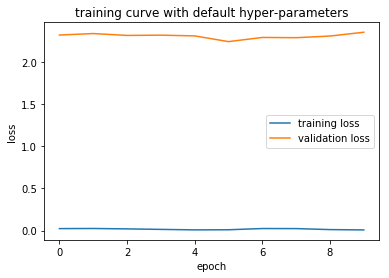

In [283]:
plt.plot(train_loss,label = 'training loss')
plt.plot(vali_loss,label = 'validation loss')
plt.title("training curve with default hyper-parameters")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

    Tune Hyper-Parameters: learning_rates

In [294]:
emb_dim = 100
learning_rates = [0.05,0.1,0.5]
num_epochs = 10

loss_history = dict()
accuracy_history = dict()

for lr in learning_rates:
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    model = BagOfWords(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    print("learning rate:{}".format(lr))
    train_loss,vali_loss = run_model(num_epochs,train_loader,model,optimizer,vali_loader)
    print ("Val Acc {0}".format(test_model(vali_loader, model)))
    print ("Test Acc {}".format(test_model(test_loader, model)))

    

Epoch: [1/10],Validation Acc: 83.28
Epoch: [2/10],Validation Acc: 71.98
Epoch: [3/10],Validation Acc: 77.94
Epoch: [4/10],Validation Acc: 80.44
Epoch: [5/10],Validation Acc: 73.58
Epoch: [6/10],Validation Acc: 74.66
Epoch: [7/10],Validation Acc: 83.04
Epoch: [8/10],Validation Acc: 78.68
Epoch: [9/10],Validation Acc: 77.52
Epoch: [10/10],Validation Acc: 80.52
learning rate:0.05
Val Acc (80.52, 2.2721121147155765)
Test Acc (79.824, 2.2797203964233375)
Epoch: [1/10],Validation Acc: 81.88
Epoch: [2/10],Validation Acc: 73.54
Epoch: [3/10],Validation Acc: 57.98
Epoch: [4/10],Validation Acc: 76.94
Epoch: [5/10],Validation Acc: 73.68
Epoch: [6/10],Validation Acc: 88.12
Epoch: [7/10],Validation Acc: 56.4
Epoch: [8/10],Validation Acc: 83.2
Epoch: [9/10],Validation Acc: 77.72
Epoch: [10/10],Validation Acc: 74.98
learning rate:0.1
Val Acc (74.98, 2.3301225555419913)
Test Acc (80.212, 2.2767430051422104)
Epoch: [1/10],Validation Acc: 92.96
Epoch: [2/10],Validation Acc: 74.68
Epoch: [3/10],Validatio

In [415]:
learning_rate_result = pd.DataFrame({'Learning_Rate':[0.01,0.05,0.10,0.50],'Optimizer':'Adam','Embedding_Size':100,'Vocabulary_Size':10000,'Max_Validation_Accuracy':[83.62,83.28,88.12,92.96],'Last_Validation_Accuracy':[72.66,80.52,74.98,79.84]})

In [416]:
learning_rate_result

,Learning_Rate,Optimizer,Embedding_Size,Vocabulary_Size,Max_Validation_Accuracy,Last_Validation_Accuracy
0,0.01,Adam,100,10000,83.62,72.66
1,0.05,Adam,100,10000,83.28,80.52
2,0.10,Adam,100,10000,88.12,74.98
3,0.50,Adam,100,10000,92.96,79.84


In [310]:
best_accuracy = max(learning_rate_result['Final Test Accuracy'])
best_learning_rate = learning_rate_result[
    learning_rate_result['Final Test Accuracy'] == best_accuracy]['learning_rate'].values[0]
print("Best test accuracy:{}".format(best_accuracy))
print("Associated learning rate:{}".format(best_learning_rate))

Best test accuracy:80.98
Associated learning rate:0.5


In [ ]:
for lr in learning_rates:
    plt.plot(loss_history[lr]['train_loss'],label = 'training loss (learning_rate={})'.format(lr))
    plt.plot(loss_history[lr]['vali_loss'],label = 'validation loss (learning_rate={})'.format(lr))

plt.title("training curve with different learning rates")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

    Tune Optimizer

In [314]:
optimizer_list = ['Adam','SGD']
num_epochs = 10
emb_dim = 100
learning_rate = best_learning_rate

loss_history = dict()
accuracy_history = dict()

for opt in optimizer_list:
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    model = BagOfWords(len(id2token), emb_dim)
    if opt == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if opt == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    print("Optimizer:{}".format(opt))
    train_loss,vali_loss = run_model(num_epochs,train_loader,model,optimizer,vali_loader)
    print ("Val Acc {0}".format(test_model(vali_loader, model)[0]))
    print ("Test Acc {}".format(test_model(test_loader, model)[0]))
    print("\n")
    

optimizer:Adam
Epoch: [1/10],Validation Acc: 63.6
Epoch: [2/10],Validation Acc: 76.2
Epoch: [3/10],Validation Acc: 83.08
Epoch: [4/10],Validation Acc: 64.94
Epoch: [5/10],Validation Acc: 83.78
Epoch: [6/10],Validation Acc: 74.8
Epoch: [7/10],Validation Acc: 76.22
Epoch: [8/10],Validation Acc: 77.96
Epoch: [9/10],Validation Acc: 80.64
Epoch: [10/10],Validation Acc: 79.06
Val Acc 79.06
Test Acc 81.216
optimizer:SGD
Epoch: [1/10],Validation Acc: 58.76
Epoch: [2/10],Validation Acc: 48.04
Epoch: [3/10],Validation Acc: 48.68
Epoch: [4/10],Validation Acc: 57.56
Epoch: [5/10],Validation Acc: 62.38
Epoch: [6/10],Validation Acc: 58.06
Epoch: [7/10],Validation Acc: 56.26
Epoch: [8/10],Validation Acc: 75.56
Epoch: [9/10],Validation Acc: 68.62
Epoch: [10/10],Validation Acc: 78.74
Val Acc 78.74
Test Acc 78.808


In [417]:
optimizer_result = pd.DataFrame({'Learning_Rate':learning_rate,'Optimizer':optimizer_list,'Embedding_Size':100,'Vocabulary_Size':10000,'Max_Validation_Accuracy':[83.08,78.74],'Last_Validation_Accuracy':[79.06,78.75]})

In [418]:
optimizer_result

,Learning_Rate,Optimizer,Embedding_Size,Vocabulary_Size,Max_Validation_Accuracy,Last_Validation_Accuracy
0,0.5,Adam,100,10000,83.08,79.06
1,0.5,SGD,100,10000,78.74,78.75


In [331]:
best_accuracy = max(optimizer_result['Final Test Accuracy'])
best_optimizer = optimizer_result[
    optimizer_result['Final Test Accuracy'] == best_accuracy]['Optimizer'].values[0]
print("Best test accuracy:{}".format(best_accuracy))
print("Associated optimizer:{}".format(best_optimizer))

Best test accuracy:81.216
Associated optimizer:Adam


    Tune Embedding-Size

In [318]:
num_epochs = 10
emb_dim_list = [50,100,150,200,300,500]
learning_rate = best_learning_rate

loss_history = dict()
accuracy_history = dict()

for emb_dim in emb_dim_list:
    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    model = BagOfWords(len(id2token), emb_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    print("Embedding_Size:{}".format(emb_dim))
    train_loss,vali_loss = run_model(num_epochs,train_loader,model,optimizer,vali_loader)
    print ("Val Acc {0}".format(test_model(vali_loader, model)[0]))
    print ("Test Acc {}".format(test_model(test_loader, model)[0]))
    print("\n")
    

Embedding_Size:50
Epoch: [1/10],Validation Acc: 86.78
Epoch: [2/10],Validation Acc: 80.36
Epoch: [3/10],Validation Acc: 60.62
Epoch: [4/10],Validation Acc: 74.18
Epoch: [5/10],Validation Acc: 69.22
Epoch: [6/10],Validation Acc: 71.76
Epoch: [7/10],Validation Acc: 81.46
Epoch: [8/10],Validation Acc: 66.72
Epoch: [9/10],Validation Acc: 77.18
Epoch: [10/10],Validation Acc: 80.84
Val Acc 80.84
Test Acc 80.672


Embedding_Size:100
Epoch: [1/10],Validation Acc: 59.78
Epoch: [2/10],Validation Acc: 78.22
Epoch: [3/10],Validation Acc: 64.52
Epoch: [4/10],Validation Acc: 76.72
Epoch: [5/10],Validation Acc: 75.4
Epoch: [6/10],Validation Acc: 84.48
Epoch: [7/10],Validation Acc: 83.6
Epoch: [8/10],Validation Acc: 80.58
Epoch: [9/10],Validation Acc: 83.06
Epoch: [10/10],Validation Acc: 73.2
Val Acc 73.2
Test Acc 80.148


Embedding_Size:150
Epoch: [1/10],Validation Acc: 60.96
Epoch: [2/10],Validation Acc: 83.48
Epoch: [3/10],Validation Acc: 75.54
Epoch: [4/10],Validation Acc: 84.06
Epoch: [5/10],Vali

In [419]:
embedding_size_result = pd.DataFrame({'Learning_Rate':learning_rate,'Optimizer':'Adam','Embedding_Size':emb_dim_list,'Vocabulary_Size':10000,'Max_Validation_Accuracy':[86.78,84.48,84.06,83.76,83.08,89.9],'Last_Validation_Accuracy':[80.84,73.2,82.06,73.4,79.08,82.48]})

In [420]:
embedding_size_result

,Learning_Rate,Optimizer,Embedding_Size,Vocabulary_Size,Max_Validation_Accuracy,Last_Validation_Accuracy
0,0.5,Adam,50,10000,86.78,80.84
1,0.5,Adam,100,10000,84.48,73.20
2,0.5,Adam,150,10000,84.06,82.06
3,0.5,Adam,200,10000,83.76,73.40
4,0.5,Adam,300,10000,83.08,79.08
5,0.5,Adam,500,10000,89.90,82.48


In [326]:
best_accuracy = max(embedding_size_result['Final Test Accuracy'])
best_embedding_size = embedding_size_result[
    embedding_size_result['Final Test Accuracy'] == best_accuracy]['Embedding_Size'].values[0]
print("Best test accuracy:{}".format(best_accuracy))
print("Associated embedding_size:{}".format(best_embedding_size))

Best test accuracy:81.104
Associated embedding_size:300


    Building n-grams and re-train the model

In [361]:
#save all tokens in local for convenience
# val set tokens
print ("Tokenizing validation data (bigram)")
vali_data_tokens_bigram, _ = tokenize_dataset_ngram(vali['reviews'],2)
pkl.dump(vali_data_tokens_bigram, open("token data/vali_data_tokens_bigram.p", "wb"))

# test set tokens
print ("Tokenizing test data (bigram)")
test_data_tokens_bigram, _ = tokenize_dataset_ngram(test['reviews'],2)
pkl.dump(test_data_tokens_bigram, open("token data/test_data_tokens_bigram.p", "wb"))

# train set tokens
print ("Tokenizing train data (bigram)")
train_data_tokens_bigram, all_train_tokens_bigram = tokenize_dataset_ngram(train['reviews'],2)
pkl.dump(train_data_tokens_bigram, open("token data/train_data_tokens_bigram.p", "wb"))
pkl.dump(all_train_tokens_bigram, open("token data/all_train_tokens_bigram.p", "wb"))

Tokenizing validation data (bigram)
Tokenizing test data (bigram)
Tokenizing train data (bigram)


In [362]:
# double checking dataset size
print ("Train dataset (bigram) size is {}".format(len(train_data_tokens_bigram)))
print ("Val dataset(bigram) size is {}".format(len(vali_data_tokens_bigram)))
print ("Test dataset(bigram) size is {}".format(len(test_data_tokens_bigram)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_bigram)))

Train dataset (bigram) size is 20000
Val dataset(bigram) size is 5000
Test dataset(bigram) size is 25000
Total number of tokens in train dataset is 4838141


In [367]:
token2id_bigram, id2token_bigram = build_vocab(all_train_tokens_bigram)

In [368]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token_bigram)-1)
random_token = id2token_bigram[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token_bigram[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id_bigram[random_token]))

Token id 9328 ; token and intelligent
Token and intelligent; token id 9328


In [397]:
train_data_indices_bigram = token2index_dataset(train_data_tokens_bigram,token2id_bigram)
vali_data_indices_bigram = token2index_dataset(vali_data_tokens_bigram,token2id_bigram)
test_data_indices_bigram = token2index_dataset(test_data_tokens_bigram,token2id_bigram)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_bigram)))
print ("Vali dataset size is {}".format(len(vali_data_indices_bigram)))
print ("Test dataset size is {}".format(len(test_data_indices_bigram)))

Train dataset size is 20000
Vali dataset size is 5000
Test dataset size is 25000


In [399]:
#re-train the model with new data
BATCH_SIZE = 32
bigram_train_loader = create_data_loader(BATCH_SIZE,train_data_indices_bigram,train['y'])
bigram_vali_loader = create_data_loader(BATCH_SIZE,vali_data_indices_bigram,vali['y'])
bigram_test_loader = create_data_loader(BATCH_SIZE,test_data_indices_bigram,test['y'])

In [439]:
emb_dim = 100
model = BagOfWords(len(id2token_bigram), emb_dim)
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [451]:
train_loss_history = []
vali_loss_history = []

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (data, lengths, labels) in enumerate(bigram_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    vali_acc,vali_loss = test_model(bigram_vali_loader, model)
    train_loss_history.append(running_loss)
    vali_loss_history.append(vali_loss)
    
    print('Epoch: [{}/{}],Validation Acc: {}'.format( 
                               epoch+1, num_epochs, vali_acc))

Epoch: [1/10],Validation Acc: 73.86
Epoch: [2/10],Validation Acc: 74.8
Epoch: [3/10],Validation Acc: 73.3
Epoch: [4/10],Validation Acc: 70.9
Epoch: [5/10],Validation Acc: 73.56
Epoch: [6/10],Validation Acc: 70.5
Epoch: [7/10],Validation Acc: 74.58
Epoch: [8/10],Validation Acc: 70.3
Epoch: [9/10],Validation Acc: 72.98
Epoch: [10/10],Validation Acc: 75.4


In [452]:
print("After training for {} epochs".format(num_epochs))
print ("Val Acc {0}".format(test_model(bigram_vali_loader, model)[0]))
print ("Test Acc {}".format(test_model(bigram_test_loader, model)[0]))

After training for 10 epochs
Val Acc 75.4
Test Acc 77.948


Text(0.5,1,'Training on Bi-gram BOW Model\n(lr = 0.01; embedding_size = 100; vocabulary_size = 10000)')

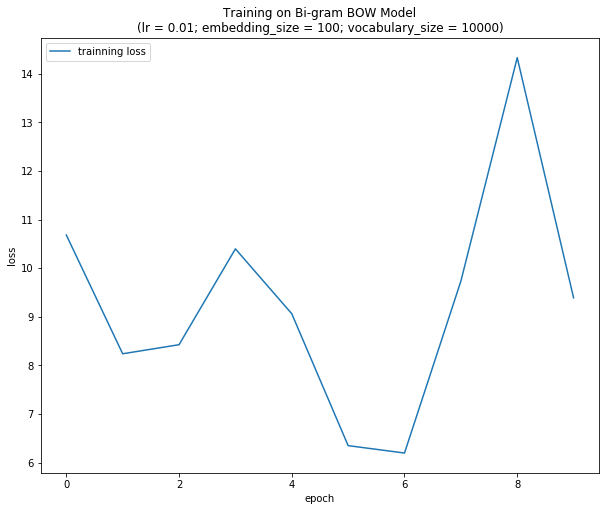

In [454]:
plt.figure(figsize=(10,8))
plt.plot(train_loss_history,label='trainning loss')
#plt.plot(vali_loss_history,label='validation loss')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training on Bi-gram BOW Model\n(lr = 0.01; embedding_size = 100; vocabulary_size = 10000)")

    Try tri-gram

In [426]:
print ("Tokenizing validation data (trigram)")
vali_data_tokens_trigram, _ = tokenize_dataset_ngram(vali['reviews'],3)
pkl.dump(vali_data_tokens_bigram, open("token data/vali_data_tokens_trigram.p", "wb"))

# test set tokens
print ("Tokenizing test data (trigram)")
test_data_tokens_trigram, _ = tokenize_dataset_ngram(test['reviews'],3)
pkl.dump(test_data_tokens_bigram, open("token data/test_data_tokens_trigram.p", "wb"))

# train set tokens
print ("Tokenizing train data (trigram)")
train_data_tokens_trigram, all_train_tokens_trigram = tokenize_dataset_ngram(train['reviews'],3)
pkl.dump(train_data_tokens_bigram, open("token data/train_data_tokens_trigram.p", "wb"))
pkl.dump(all_train_tokens_bigram, open("token data/all_train_tokens_trigram.p", "wb"))

Tokenizing validation data (trigram)
Tokenizing test data (trigram)
Tokenizing train data (trigram)


In [427]:
# double checking dataset size
print ("Train dataset (trigram) size is {}".format(len(train_data_tokens_trigram)))
print ("Val dataset(trigram) size is {}".format(len(vali_data_tokens_trigram)))
print ("Test dataset(trigram) size is {}".format(len(test_data_tokens_trigram)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_trigram)))

Train dataset (trigram) size is 20000
Val dataset(trigram) size is 5000
Test dataset(trigram) size is 25000
Total number of tokens in train dataset is 4818141


In [438]:
token2id_trigram, id2token_trigram = build_vocab(all_train_tokens_trigram)

In [471]:
train_data_indices_trigram = token2index_dataset(train_data_tokens_trigram,token2id_trigram)
vali_data_indices_trigram = token2index_dataset(vali_data_tokens_trigram,token2id_trigram)
test_data_indices_trigram = token2index_dataset(test_data_tokens_trigram,token2id_trigram)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices_trigram)))
print ("Vali dataset size is {}".format(len(vali_data_indices_trigram)))
print ("Test dataset size is {}".format(len(test_data_indices_trigram)))

Train dataset size is 20000
Vali dataset size is 5000
Test dataset size is 25000


In [479]:
#re-train the model with new data
BATCH_SIZE = 32
trigram_train_loader = create_data_loader(BATCH_SIZE,train_data_indices_trigram,train['y'])
trigram_vali_loader = create_data_loader(BATCH_SIZE,vali_data_indices_trigram,vali['y'])
trigram_test_loader = create_data_loader(BATCH_SIZE,test_data_indices_trigram,test['y'])

In [480]:
emb_dim = 100
model = BagOfWords(len(id2token_trigram), emb_dim)
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [501]:
def do_train(dataloader):
    model.train()
    loss_val = 0
    for i, (data, lengths, labels) in enumerate(dataloader):
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        
        # Accurately compute loss, because of different batch size
        loss_val += loss.item() * len(data) / len(dataloader.dataset)
    return loss.item()

In [542]:
def do_eval(dataloader):
    model.eval()
    loss_val = 0
   
    with torch.no_grad():
        for i, (data, lengths, labels) in enumerate(dataloader):
            data_batch, length_batch, label_batch = data, lengths, labels
            outputs = model(data_batch, length_batch)
            loss = criterion(outputs, label_batch)
            loss_val += loss.item()
    optimizer.zero_grad()
    return loss_val

In [503]:
for epoch in range(num_epochs):
    for i, (data, lengths, labels) in enumerate(trigram_train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
    
    vali_acc,vali_loss = test_model(trigram_vali_loader, model)
    
    print('Epoch: [{}/{}],Validation Acc: {}'.format( 
                               epoch+1, num_epochs, vali_acc))

Epoch: [1/10],Validation Acc: 62.54
Epoch: [2/10],Validation Acc: 71.44
Epoch: [3/10],Validation Acc: 71.0
Epoch: [4/10],Validation Acc: 68.18
Epoch: [5/10],Validation Acc: 66.88
Epoch: [6/10],Validation Acc: 64.74
Epoch: [7/10],Validation Acc: 69.6
Epoch: [8/10],Validation Acc: 64.58
Epoch: [9/10],Validation Acc: 68.26
Epoch: [10/10],Validation Acc: 66.64


In [504]:
print("After training for {} epochs".format(num_epochs))
print ("Val Acc {0}".format(test_model(trigram_vali_loader, model)[0]))
print ("Test Acc {}".format(test_model(trigram_test_loader, model)[0]))

After training for 10 epochs
Val Acc 66.64
Test Acc 72.252


    Tune different vocabulary size

In [506]:
def run_model_default_setting(id2token,train_loader,vali_loader):
    emb_dim = 100
    model = BagOfWords(len(id2token), emb_dim)
    learning_rate = 0.01
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss,vali_loss = run_model(num_epochs,train_loader,model,optimizer,vali_loader)

In [508]:
vocabulary_size_lists = [5000,10000,15000,20000]
for vocab_size in vocabulary_size_lists:
    token2id, id2token = build_vocab(all_train_tokens,vocab_size)
    
    train_data_indices = token2index_dataset(train_data_tokens,token2id)
    vali_data_indices = token2index_dataset(vali_data_tokens,token2id)
    test_data_indices = token2index_dataset(test_data_tokens,token2id)
    
    if (len(train_data_indices) == 20000) & (len(vali_data_indices) == 5000) & (len(test_data_indices) == 25000):
        train_loader = create_data_loader(BATCH_SIZE,train_data_indices,train['y'])
        vali_loader = create_data_loader(BATCH_SIZE,vali_data_indices,vali['y'])
        test_loader = create_data_loader(BATCH_SIZE,test_data_indices,test['y'])
        
        print("vocabulary size:{}".format(vocab_size))
        run_model_default_setting(id2token,train_loader,vali_loader)
    else:
        print("token to index step was wrong, please check!")
        break



vocabulary size:5000
Epoch: [1/10],Validation Acc: 76.2
Epoch: [2/10],Validation Acc: 76.44
Epoch: [3/10],Validation Acc: 83.56
Epoch: [4/10],Validation Acc: 75.04
Epoch: [5/10],Validation Acc: 78.9
Epoch: [6/10],Validation Acc: 79.6
Epoch: [7/10],Validation Acc: 79.62
Epoch: [8/10],Validation Acc: 79.22
Epoch: [9/10],Validation Acc: 81.52
Epoch: [10/10],Validation Acc: 78.12
vocabulary size:10000
Epoch: [1/10],Validation Acc: 85.14
Epoch: [2/10],Validation Acc: 78.1
Epoch: [3/10],Validation Acc: 80.36
Epoch: [4/10],Validation Acc: 74.38
Epoch: [5/10],Validation Acc: 74.58
Epoch: [6/10],Validation Acc: 80.86
Epoch: [7/10],Validation Acc: 76.36
Epoch: [8/10],Validation Acc: 79.08
Epoch: [9/10],Validation Acc: 75.54
Epoch: [10/10],Validation Acc: 78.16
vocabulary size:15000
Epoch: [1/10],Validation Acc: 74.92
Epoch: [2/10],Validation Acc: 79.36
Epoch: [3/10],Validation Acc: 82.36
Epoch: [4/10],Validation Acc: 79.4
Epoch: [5/10],Validation Acc: 82.74
Epoch: [6/10],Validation Acc: 80.38
Ep

In [510]:
vocab_size_result = pd.DataFrame({'Learning_Rate':0.01,'Optimizer':'Adam','Embedding_Size':100,'Vocabulary_Size':vocabulary_size_lists,'Max_Validation_Accuracy':[83.56,85.14,82.82,84.4],'Last_Validation_Accuracy':[78.12,78.16,82.82,77.8]})

In [511]:
vocab_size_result

,Learning_Rate,Optimizer,Embedding_Size,Vocabulary_Size,Max_Validation_Accuracy,Last_Validation_Accuracy
0,0.01,Adam,100,5000,83.56,78.12
1,0.01,Adam,100,10000,85.14,78.16
2,0.01,Adam,100,15000,82.82,82.82
3,0.01,Adam,100,20000,84.40,77.80


    Try n-grams combined BOW

In [516]:
def tokenize_dataset_ngram_combined(dataset,n_gram):
    token_dataset = []
    all_tokens = []
    
    for text in dataset:
        #tokenize and remove punctuations
        tokens = nltk.word_tokenize(text)
        tokens = [token.lower() for token in tokens if (token not in punctuations)]
        combined_tokens = []
        
        for i in range(1,n_gram + 1):
            n_grams_tokens = ngrams(tokens,i)
            n_grams_tokens = [' '.join(grams) for grams in n_grams_tokens]
            combined_tokens += n_grams_tokens
            
        token_dataset.append(combined_tokens)
        all_tokens += combined_tokens

    return token_dataset, all_tokens

In [517]:
print ("Tokenizing validation data (combined)")
vali_data_tokens_comb, _ = tokenize_dataset_ngram_combined(vali['reviews'],2)
pkl.dump(vali_data_tokens_comb, open("token data/vali_data_tokens_combined.p", "wb"))

# test set tokens
print ("Tokenizing test data (combined)")
test_data_tokens_comb, _ = tokenize_dataset_ngram_combined(test['reviews'],2)
pkl.dump(test_data_tokens_comb, open("token data/test_data_tokens_combined.p", "wb"))

# train set tokens
print ("Tokenizing train data (combined)")
train_data_tokens_comb, all_train_tokens_comb = tokenize_dataset_ngram_combined(train['reviews'],2)
pkl.dump(train_data_tokens_comb, open("token data/train_data_tokens_combined.p", "wb"))
pkl.dump(all_train_tokens_comb, open("token data/all_train_tokens_combined.p", "wb"))

Tokenizing validation data (trigram)
Tokenizing test data (trigram)
Tokenizing train data (trigram)


In [518]:
# double checking dataset size
print ("Train dataset (combined) size is {}".format(len(train_data_tokens_comb)))
print ("Val dataset(combined) size is {}".format(len(vali_data_tokens_comb)))
print ("Test dataset(combined) size is {}".format(len(test_data_tokens_comb)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens_comb)))

Train dataset (combined) size is 20000
Val dataset(combined) size is 5000
Test dataset(combined) size is 25000
Total number of tokens in train dataset is 9696282


In [532]:
token2id_comb, id2token_comb = build_vocab(all_train_tokens_comb,10000)

In [533]:
train_data_indices_comb = token2index_dataset(train_data_tokens_comb,token2id_comb)
vali_data_indices_comb = token2index_dataset(vali_data_tokens_comb,token2id_comb)
test_data_indices_comb = token2index_dataset(test_data_tokens_comb,token2id_comb)

In [534]:
if (len(train_data_indices_comb) == 20000) & (len(vali_data_indices_comb) == 5000) & (len(test_data_indices_comb) == 25000):
    comb_train_loader = create_data_loader(BATCH_SIZE,train_data_indices_comb,train['y'])
    comb_vali_loader = create_data_loader(BATCH_SIZE,vali_data_indices_comb,vali['y'])
    comb_test_loader = create_data_loader(BATCH_SIZE,test_data_indices_comb,test['y'])

    emb_dim = 100
    model = BagOfWords(len(id2token_comb), emb_dim)
    learning_rate = 0.01
    num_epochs = 10 # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    run_model(num_epochs,comb_train_loader,model,optimizer,comb_vali_loader)
    print("After running 10 epochs")
    print ("Val Acc {0}".format(test_model(comb_vali_loader, model)[0]))
else:
    print("token to index step was wrong, please check!")

Epoch: [1/10],Validation Acc: 76.86
Epoch: [2/10],Validation Acc: 82.84
Epoch: [3/10],Validation Acc: 74.22
Epoch: [4/10],Validation Acc: 74.94
Epoch: [5/10],Validation Acc: 79.46
Epoch: [6/10],Validation Acc: 75.52
Epoch: [7/10],Validation Acc: 77.76
Epoch: [8/10],Validation Acc: 78.02
Epoch: [9/10],Validation Acc: 76.18
Epoch: [10/10],Validation Acc: 77.96
After running 10 epochs
Val Acc 77.96


In [535]:
n_grams_result = pd.DataFrame({'n-gram':['1_gram','bi-gram','tri_gram','1+2_grams'],'Learning_Rate':0.01,'Optimizer':'Adam','Embedding_Size':100,'Vocabulary_Size':10000,'Max_Validation_Accuracy':[83.62,75.4,71.44,82.84],'Last_Validation_Accuracy':[72.66,75.4,66.64,77.96]})

In [536]:
n_grams_result

,n-gram,Learning_Rate,Optimizer,Embedding_Size,Vocabulary_Size,Max_Validation_Accuracy,Last_Validation_Accuracy
0,1_gram,0.01,Adam,100,10000,83.62,72.66
1,bi-gram,0.01,Adam,100,10000,75.40,75.40
2,tri_gram,0.01,Adam,100,10000,71.44,66.64
3,1+2_grams,0.01,Adam,100,10000,82.84,77.96


In [543]:
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
learning_rate = 0.01
num_epochs = 10 # number epoch to train

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    
for epoch in range(num_epochs):
    running_loss = 0
    for i, (data, lengths, labels) in enumerate(train_loader):
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    vali_loss = do_eval(vali_loader)

    
    print('Epoch: [{}/{}],Training Loss: {},Validation Loss:{}'.format( 
                               epoch+1, num_epochs, running_loss,vali_loss))

Epoch: [1/10],Training Loss: 258.72273148596287,Validation Loss:72.68006438016891
Epoch: [2/10],Training Loss: 118.35792031139135,Validation Loss:64.18999163806438
Epoch: [3/10],Training Loss: 66.72399761527777,Validation Loss:109.0859994739294
Epoch: [4/10],Training Loss: 35.44490148127079,Validation Loss:111.71872924268246
Epoch: [5/10],Training Loss: 19.480756975710392,Validation Loss:173.04688522219658
Epoch: [6/10],Training Loss: 8.541881404817104,Validation Loss:217.13850861787796
Epoch: [7/10],Training Loss: 4.082879945635796,Validation Loss:203.91680997610092
Epoch: [8/10],Training Loss: 1.3065952956676483,Validation Loss:234.37704062461853
Epoch: [9/10],Training Loss: 0.4623711556196213,Validation Loss:223.4012978374958
Epoch: [10/10],Training Loss: 0.2628939300775528,Validation Loss:249.13265632092953
